# Run on Q hardware

First actual step.

> 04-02

$\boxed{H_2 \text{ computed -1.857275, (adding nuclear repulsion -> -1.137306 (actual))}}$

## Initial, running on simulator

Copy from [this file](../../VQE/8-modifying-and-researching.ipynb)

[+ StatevectorEstimator](https://docs.quantum.ibm.com/api/qiskit/qiskit.primitives.StatevectorEstimator)

MOLECULAR STRUCTURE:
orbitals:  2
particles:  (1, 1)

QUBIT HAMILTONIAN:
SparsePauliOp(['IIII', 'IIIZ', 'IIZI', 'IIZZ', 'IZII', 'IZIZ', 'ZIII', 'ZIIZ', 'YYYY', 'XXYY', 'YYXX', 'XXXX', 'IZZI', 'ZIZI', 'ZZII'],
              coeffs=[-0.81054798+0.j,  0.17218393+0.j, -0.22575349+0.j,  0.12091263+0.j,
  0.17218393+0.j,  0.16892754+0.j, -0.22575349+0.j,  0.16614543+0.j,
  0.0452328 +0.j,  0.0452328 +0.j,  0.0452328 +0.j,  0.0452328 +0.j,
  0.16614543+0.j,  0.17464343+0.j,  0.12091263+0.j])

RESULTS:
Optimal Parameters: [-6.91920998e-08 -1.18038255e-07 -1.11936379e-01]
Optimal Energy: -1.857274984196156


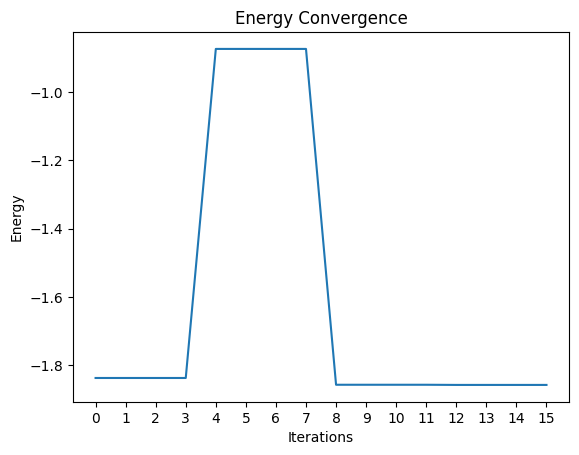

In [1]:
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.units import DistanceUnit
from qiskit_algorithms.optimizers import L_BFGS_B
from qiskit_nature.second_q.circuit.library import HartreeFock, UCCSD
import numpy as np
from qiskit.primitives import StatevectorEstimator
from matplotlib import pyplot as plt

driver = PySCFDriver(
    atom='H .0 .0 .0; H .0 .0 0.735',
    unit=DistanceUnit.ANGSTROM,
    basis='sto3g',
)
problem = driver.run()

print("MOLECULAR STRUCTURE:")
print("orbitals: ", problem.num_spatial_orbitals)
print("particles: ", problem.num_particles)

from qiskit_nature.second_q.mappers import JordanWignerMapper

mapper = JordanWignerMapper()

qubit_hamiltonian = mapper.map(problem.hamiltonian.second_q_op())
print("\nQUBIT HAMILTONIAN:")
print(qubit_hamiltonian)

optimizer = L_BFGS_B(maxfun=15)

ansatz = UCCSD(
    problem.num_spatial_orbitals,
    problem.num_particles,
    mapper,
    initial_state=HartreeFock(
        problem.num_spatial_orbitals,
        problem.num_particles,
        mapper,
    ),
)

initial_point = np.zeros(ansatz.num_parameters)
estimator = StatevectorEstimator()
results = []

def estimate_energy(parameters):
    job = estimator.run(
        [(ansatz, qubit_hamiltonian, parameters)]
    )
    result = job.result()[0].data.evs
    results.append(result)
    return result

result = optimizer.minimize(fun=estimate_energy, x0=initial_point)

print("\nRESULTS:")
print("Optimal Parameters:", result.x)
print("Optimal Energy:", result.fun)

plt.plot(results)
plt.xlabel('Iterations')
plt.xticks(range(len(results)))
plt.ylabel('Energy')
plt.title('Energy Convergence')
plt.show()


## Basic example of running iterations on IBMQ

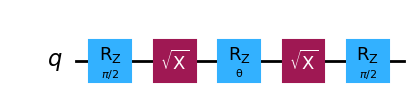

In [2]:
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
import numpy as np

qc1 = QuantumCircuit(1)
theta = Parameter('θ')

qc1.rz(np.pi/2, 0)
qc1.sx(0)
qc1.rz(theta, 0)
qc1.sx(0)
qc1.rz(np.pi/2, 0)

qc1.draw(output='mpl')

In [3]:
from qiskit.primitives import StatevectorEstimator as EstimatorSim
from qiskit.quantum_info import Pauli

estimator_sim = EstimatorSim()
observable = Pauli("Z")
initial_params = [0.3]

job = estimator_sim.run(
        [(qc1, observable, initial_params)],
    )
result = job.result()[0].data.evs
print(result)

result = result - 0.5
job = estimator_sim.run(
        [(qc1, observable, [result])],
    )
result = job.result()[0].data.evs
print(result)


-0.9553364891256056
-0.1152034765882376


In [4]:
from qiskit import transpile
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import EstimatorV2 as Estimator

backend_name = "ibm_brisbane"
service = QiskitRuntimeService()
backend = service.backend(backend_name)
print("Done getting backend")

Done getting backend


In [5]:
observable = Pauli("Z")
transpiled_qcs = transpile([qc1], backend=backend, optimization_level=1)
observable = observable.apply_layout(transpiled_qcs[0].layout)

estimator = Estimator(mode=backend)
estimator.options.resilience_level = 1
estimator.options.dynamical_decoupling.enable = True
estimator.options.dynamical_decoupling.sequence_type = "XY4"

In [6]:
# not using transpiled
initial_params = [0.3]

job2 = estimator.run([(qc1, Pauli("Z"), initial_params)])
print(f"Job submitted: {job2.job_id()}")

# Wait for the job to complete
result = job2.result()
print(result[0].data.evs)

Job submitted: czxa670rxz8g008f1nm0
-0.9506973089766254


In [7]:

initial_params = [0.3]

job2 = estimator.run([(transpiled_qcs[0], observable, initial_params)])
print(f"Job submitted: {job2.job_id()}")

# Wait for the job to complete
result = job2.result()
print(result[0].data.evs)

Job submitted: czxa6hjnhqag008tmea0
-0.9674076988654994


In [8]:
from datetime import datetime
def timestamp():
    return datetime.now()

initial_params = [0.1]
job2 = estimator.run([(transpiled_qcs[0], observable, initial_params)])
print(f"{timestamp()} Job submitted: {job2.job_id()}")

# Wait for the job to complete
result = job2.result()[0].data.evs
print(f"{timestamp()} {result}")

result = result - 0.5

job2 = estimator.run([(transpiled_qcs[0], observable, [result])])
print(f"{timestamp()} Job submitted: {job2.job_id()}")

# Wait for the job to complete
result = job2.result()[0].data.evs
print(f"{timestamp()} {result}")


2025-04-12 19:31:06.641229 Job submitted: czxa6pakzhn0008d4jx0
2025-04-12 19:31:24.773282 -0.9928161866473341
2025-04-12 19:31:27.025754 Job submitted: czxa6vbnhqag008tmedg


KeyboardInterrupt: 

## Bit by bit try VQE on IBMQ

In [9]:
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.units import DistanceUnit
from qiskit_algorithms.optimizers import L_BFGS_B
from qiskit_nature.second_q.circuit.library import HartreeFock, UCCSD
import numpy as np
from matplotlib import pyplot as plt

driver = PySCFDriver(
    atom='H .0 .0 .0; H .0 .0 0.735',
    unit=DistanceUnit.ANGSTROM,
    basis='sto3g',
)
problem = driver.run()

print("MOLECULAR STRUCTURE:")
print("orbitals: ", problem.num_spatial_orbitals)
print("particles: ", problem.num_particles)

from qiskit_nature.second_q.mappers import JordanWignerMapper

mapper = JordanWignerMapper()

qubit_hamiltonian = mapper.map(problem.hamiltonian.second_q_op())
print("\nQUBIT HAMILTONIAN:")
print(qubit_hamiltonian)

# optimizer = L_BFGS_B(maxfun=20)

ansatz = UCCSD(
    problem.num_spatial_orbitals,
    problem.num_particles,
    mapper,
    initial_state=HartreeFock(
        problem.num_spatial_orbitals,
        problem.num_particles,
        mapper,
    ),
)

initial_point = np.zeros(ansatz.num_parameters)
results = []

MOLECULAR STRUCTURE:
orbitals:  2
particles:  (1, 1)

QUBIT HAMILTONIAN:
SparsePauliOp(['IIII', 'IIIZ', 'IIZI', 'IIZZ', 'IZII', 'IZIZ', 'ZIII', 'ZIIZ', 'YYYY', 'XXYY', 'YYXX', 'XXXX', 'IZZI', 'ZIZI', 'ZZII'],
              coeffs=[-0.81054798+0.j,  0.17218393+0.j, -0.22575349+0.j,  0.12091263+0.j,
  0.17218393+0.j,  0.16892754+0.j, -0.22575349+0.j,  0.16614543+0.j,
  0.0452328 +0.j,  0.0452328 +0.j,  0.0452328 +0.j,  0.0452328 +0.j,
  0.16614543+0.j,  0.17464343+0.j,  0.12091263+0.j])


In [10]:
# Prep backend
from qiskit_ibm_runtime import QiskitRuntimeService

backend_name = "ibm_brisbane"
service = QiskitRuntimeService()
backend = service.backend(backend_name)
print("Done getting backend")

Done getting backend


In [11]:
# Transpile
from qiskit import transpile
from qiskit_ibm_runtime import EstimatorV2 as Estimator
observable = qubit_hamiltonian
transpiled_qcs = transpile([ansatz], backend=backend, optimization_level=1)
# observable = observable.apply_layout(transpiled_qcs[0].layout)

estimator = Estimator(mode=backend)
estimator.options.resilience_level = 1
estimator.options.dynamical_decoupling.enable = True
estimator.options.dynamical_decoupling.sequence_type = "XY4"

In [12]:
def estimate_energy(parameters):
    job = estimator.run([(transpiled_qcs[0], qubit_hamiltonian, parameters)])
    print(f"{timestamp()} Job submitted: {job.job_id()}")

    result = job.result()[0].data.evs
    results.append(result)
    return result

result = estimate_energy(initial_point)
print(f"{datetime.now()} Result: {result}")

ValueError: The number of qubits of the circuit (127) does not match the number of qubits of the ()-th observable (4).

In [ ]:
print(results)

[]
